## **Importing** **Libraries**

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader


In [ ]:
# Load labeled and new datasets
labeled_data = pd.read_csv("/content/tweets_1500.csv")
new_data = pd.read_csv("/content/lokesh_dataset.csv", encoding='ISO-8859-1')

# Rename columns for consistency
labeled_data.columns = ['tweet', 'label']
new_data.columns = ['tweet']


In [ ]:
class TweetDataset(Dataset):
    def __init__(self, tweets, labels=None, tokenizer=None, max_len=128):  #initialising the dataset
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): #defining the dataset length
        return len(self.tweets)

    def __getitem__(self, idx): 
        tweet = str(self.tweets[idx]) 
        inputs = self.tokenizer(
            tweet, max_length=self.max_len, truncation=True, padding="max_length", return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Dataset Spliting into test and train**

In [ ]:
tweets = labeled_data["tweet"].tolist()
labels = labeled_data["label"].tolist()

train_tweets, val_tweets, train_labels, val_labels = train_test_split(tweets, labels, test_size=0.2)

train_dataset = TweetDataset(train_tweets, train_labels, tokenizer)
val_dataset = TweetDataset(val_tweets, val_labels, tokenizer)


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## **Training the model for Labeling Dataset**

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()


In [ ]:
new_tweets = new_data["tweet"].tolist()
new_dataset = TweetDataset(new_tweets, tokenizer=tokenizer)
new_loader = DataLoader(new_dataset, batch_size=16)

# Perform predictions
model.eval()
predictions = []
with torch.no_grad():
    for batch in new_loader:
        inputs = {key: val.to(model.device) for key, val in batch.items() if key != "labels"}
        outputs = model(**inputs)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        predictions.extend(batch_predictions)


## **Saving Labeled Dataset**

In [ ]:
# Add predictions to the new dataset and save
new_data["label"] = predictions
new_data.to_csv("labeled_new_dataset.csv", index=False)

print("New dataset labeled and saved as 'labeled_new_dataset.csv'.")


New dataset labeled and saved as 'labeled_new_dataset.csv'.


## Starting With **Newly Labeled Dataset**

# **Importing required Libraries**

In [ ]:
import pandas as pd
import re
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# **Loading and Preprocessing**

In [ ]:
 # Load labeled dataset
data = pd.read_csv("/content/labeled_new_dataset.csv")

# Define preprocessing function for text
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower().strip()
    return text

# Apply preprocessing to tweets
data["tweet"] = data["tweet"].apply(preprocess_text)

# Preprocess and clean up labels
print("Unique labels before cleanup:", data["label"].unique())
data["label"] = pd.to_numeric(data["label"], errors="coerce")
data = data.dropna(subset=["label"])
data["label"] = data["label"].astype(int)
print("Unique labels after cleanup:", data["label"].unique())


Unique labels before cleanup: [ 1.  0. nan]
Unique labels after cleanup: [1 0]


<ipython-input-21-151c8b0483e2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["label"] = data["label"].astype(int)  # Ensure labels are integers


In [ ]:
# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data["tweet"], data["label"], test_size=0.2, random_state=42
)

# Print dataset sizes for PyTorch Dataset
print(f"Training dataset size: {len(train_texts)}")
print(f"Validation dataset size: {len(val_texts)}")



Training dataset size: 7656
Validation dataset size: 1915


In [ ]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = int(self.labels.iloc[idx])
        inputs = self.tokenizer(
            text, max_length=self.max_len, truncation=True, padding="max_length", return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Prepare datasets
train_dataset = TweetDataset(train_texts, train_labels, tokenizer)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer)


In [ ]:
# Load pre-trained BERT model for classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Set training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


<ipython-input-26-5117c6a9592a>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
+   # Train the model
trainer.train()

# Evaluate the model
metrics = trainer.evaluate()

# Print evaluation metrics
print("\nEvaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.245300,0.253694,0.895039,0.916077,0.884766,0.900149
2,0.124400,0.281362,0.908616,0.908566,0.921875,0.915172
3,0.070300,0.355030,0.908094,0.923154,0.903320,0.913129



Evaluation Metrics:
eval_loss: 0.3550
eval_accuracy: 0.9081
eval_precision: 0.9232
eval_recall: 0.9033
eval_f1: 0.9131
eval_runtime: 13.5111
eval_samples_per_second: 141.7360
eval_steps_per_second: 8.8820
epoch: 3.0000


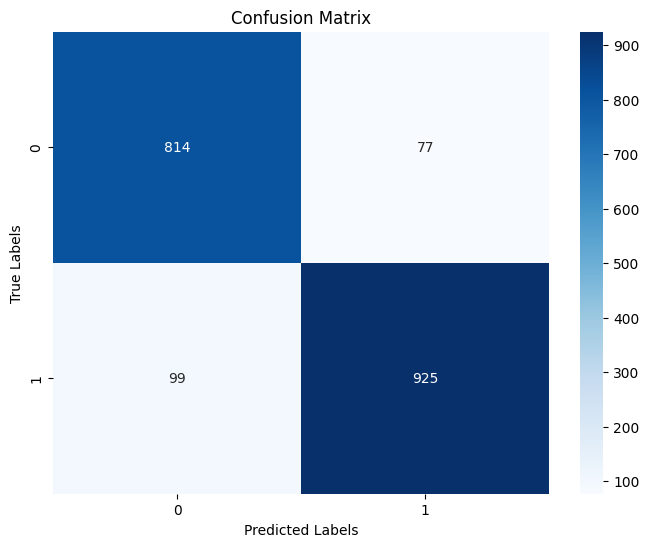


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       891
           1       0.92      0.90      0.91      1024

    accuracy                           0.91      1915
   macro avg       0.91      0.91      0.91      1915
weighted avg       0.91      0.91      0.91      1915



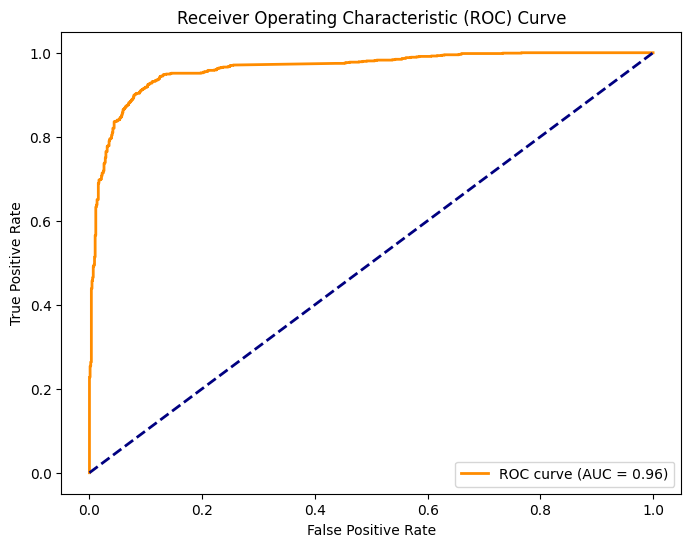

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get predictions and labels
predictions = trainer.predict(val_dataset)
pred_logits = predictions.predictions
pred_labels = np.argmax(pred_logits, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(val_labels, pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(val_labels), yticklabels=np.unique(val_labels))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Detailed classification report
print("\nClassification Report:")
print(classification_report(val_labels, pred_labels))

# Plot ROC curve (for binary classification only)
if len(np.unique(val_labels)) == 2:
    y_true_binary = (val_labels == np.unique(val_labels)[1]).astype(int)
    y_scores = pred_logits[:, 1]

    fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve is only applicable for binary classification.")


In [ ]:
import pandas as pd
import re
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import random
import nltk
nltk.download('punkt_tab')
# Download NLTK resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## **WITH DATA AUGUMENTATION**

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
data = pd.read_csv("/content/labeled_new_dataset.csv")

Using device: cuda


In [ ]:
# Preprocessing function
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower().strip()

    # Tokenize and remove stop words
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text)
    text = " ".join(word for word in words if word not in stop_words)

    return text

In [ ]:
# Data augmentation
def augment_text(text):
    augmentation_methods = [
        synonym_replacement,
        random_deletion
    ]
    # Choose a random augmentation
    method = random.choice(augmentation_methods)
    return method(text)
def synonym_replacement(text):
    words = word_tokenize(text)
    synonyms = []
    for word in words:
        synsets = nltk.corpus.wordnet.synsets(word)
        if synsets:
            synonyms.append(synsets[0].lemmas()[0].name())
        else:
            synonyms.append(word)
    return " ".join(synonyms)

def random_deletion(text, p=0.05):
    words = word_tokenize(text)
    if len(words) == 1:
        return text
    filtered = [word for word in words if random.uniform(0, 1) > p]
    return " ".join(filtered) if filtered else text

In [ ]:
# Apply preprocessing
data["tweet"] = data["tweet"].apply(preprocess_text)

In [ ]:
# Augment data
augmented_data = data.copy()
augmented_data["tweet"] = augmented_data["tweet"].apply(augment_text)

In [ ]:
# Combine original and augmented data
data = pd.concat([data, augmented_data]).reset_index(drop=True)

# Preprocessing labels
print("Unique labels before cleanup:", data["label"].unique())
data["label"] = pd.to_numeric(data["label"], errors="coerce")
data = data.dropna(subset=["label"])
data["label"] = data["label"].astype(int)
print("Unique labels after cleanup:", data["label"].unique())


Unique labels before cleanup: [ 1.  0. nan]
Unique labels after cleanup: [1 0]


In [ ]:
# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data["tweet"], data["label"], test_size=0.2, random_state=42
)


In [ ]:
# Tokenization and Dataset preparation
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = int(self.labels.iloc[idx])
        inputs = self.tokenizer(
            text, max_length=self.max_len, truncation=True, padding="max_length", return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_dataset = TweetDataset(train_texts, train_labels, tokenizer)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer)


In [ ]:
# Model and Training setup
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-15-66f7f872921c>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.185700,0.218223,0.919300,0.924671,0.919558,0.922107
2,0.172800,0.216443,0.942544,0.942029,0.947712,0.944862


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.185700,0.218223,0.919300,0.924671,0.919558,0.922107
2,0.172800,0.216443,0.942544,0.942029,0.947712,0.944862
3,0.036700,0.230144,0.947245,0.961280,0.936149,0.948548


TrainOutput(global_step=2874, training_loss=0.18048149441668948, metrics={'train_runtime': 1208.1766, 'train_samples_per_second': 38.023, 'train_steps_per_second': 2.379, 'total_flos': 3021764693045760.0, 'train_loss': 0.18048149441668948, 'epoch': 3.0})

In [ ]:
# Evaluate model
metrics = trainer.evaluate()
print("\nEvaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


Evaluation Metrics:
eval_loss: 0.2301
eval_accuracy: 0.9472
eval_precision: 0.9613
eval_recall: 0.9361
eval_f1: 0.9485
eval_runtime: 39.8295
eval_samples_per_second: 96.1350
eval_steps_per_second: 6.0260
epoch: 3.0000


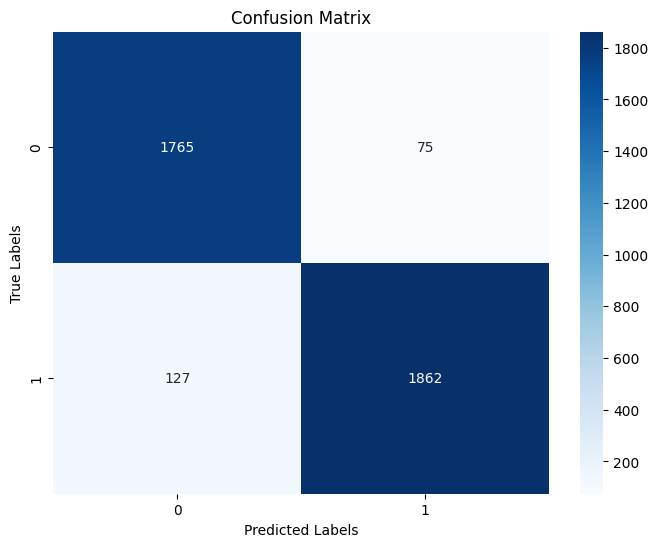


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1840
           1       0.96      0.94      0.95      1989

    accuracy                           0.95      3829
   macro avg       0.95      0.95      0.95      3829
weighted avg       0.95      0.95      0.95      3829



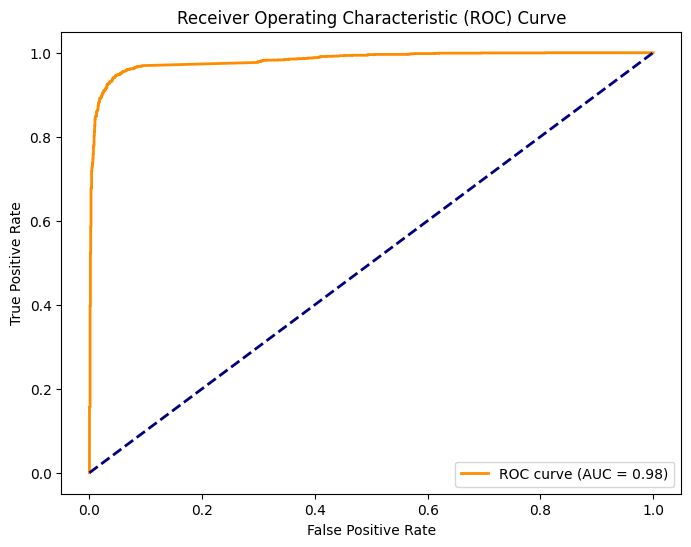

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get predictions and labels
predictions = trainer.predict(val_dataset)
pred_logits = predictions.predictions
pred_labels = np.argmax(pred_logits, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(val_labels, pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(val_labels), yticklabels=np.unique(val_labels))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Detailed classification report
print("\nClassification Report:")
print(classification_report(val_labels, pred_labels))

# Plot ROC curve (for binary classification only)
if len(np.unique(val_labels)) == 2:
    y_true_binary = (val_labels == np.unique(val_labels)[1]).astype(int)
    y_scores = pred_logits[:, 1]

    fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve is only applicable for binary classification.")
